In [1]:
from numpy import *
from IPython.display import display

In [2]:
from matplotlib.pyplot import *
%matplotlib inline

# Cubic splines with Python

In this notebook, we show how to use the `interpolation` library to interpolate a function using cubic splines.

In [3]:
# we need to import the library first
from interpolation import splines

## Interpolating a function

Our goal here, consists in approximate a function $R^d \rightarrow R$ given its values on 
a regularly spaced rectangular grid.

We consider the two dimensional function defined by $f(x,y)=sin(\sqrt{x^2+y^2}/\pi)/(\sqrt{x^2+y^2}/\pi)$ if $(x,y) \neq (0,0)$ and by $f(0,0)=1$

In [4]:
from numba import vectorize
@vectorize(['double(double, double)'])
def f(x,y):
    if x==0 and y==0:
        out = 1.0
    else:
        t = sqrt( x**2+y**2 )
        out = sin(pi*t)/(pi*t)
    return out

Value of f at (0.5,0.5) : 0.358187786013244


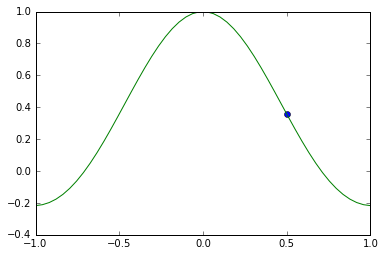

In [5]:
# Let's try it:

# The function f can be evaluated at any point
x0 = 0.5
y0 = 0.5
val = f(x0,y0)
print('Value of f at ({},{}) : {}'.format(x0,x0,val))

# Or at any list of points
x = linspace(-1,1,50)
y = linspace(-1,1,50)
vals = f(x,y)

# Plot
plot(x0, val, 'o')
plot(x, f(x,y))

The grid over which we approximate the function is defined by its boundaries $[a_i, b_i]$ and the number of points $n_i$ in each dimension $i \in [1,d]$.

In each dimension $i\in[1,d]$ the $n_i$ points $(a_i=s^0_i, s^2_i, ..., s^{n_j-1}_i=b_i)$
are regularly spaced, meaning that for any $j$, $s^j_i = a_i + j\frac{b_i-a_i}{n_i-1}$. These points are called *nodes*.

For the two dimensional function defined above, we define $[a_1,b_1]=[a_2,b_2]=[-5,5]$ and we use 50 points in each dimension.

In [6]:
# define the approximation space
a = [-5.0, -5.0]  # a_1, a_2
b = [5.0, 5.0]    # b_1, b_2
orders = [15,15]     # n_2, n_2

The cartesian product of these nodes is used to approximate the compact state $\mathcal{S}=[a_1, b_1], ... [a_d, b_d]$, by a finite set of points $S=(s_{i_1,...i_d})_{i_1\in[1,n_1], ..., i_d\in[1,n_d]}$. By definition, the point indexed by i_1,...i_d is simply the tuple $(s_{i_1},...s_{i_d})$.

In general, this multivariate index is sufficient and it is not needed to list these points one after all. By convention, we list the points as a 2d arrays, where each line corresponds to a point, and where *the last index varies faster* meaning that points are listed like in $s_{00}, s_{01}, s_{02}, s_{10}, s_{11}, s_{12}$.

This grid can be constructed using the mlinspace function, which extends the linspace function to multidimensional spaces:

First points:
[[-5.         -5.        ]
 [-5.         -4.28571429]
 [-5.         -3.57142857]
 [-5.         -2.85714286]
 [-5.         -2.14285714]
 [-5.         -1.42857143]
 [-5.         -0.71428571]
 [-5.          0.        ]
 [-5.          0.71428571]
 [-5.          1.42857143]]


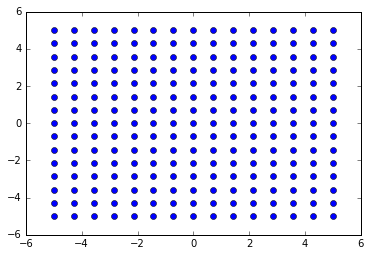

In [7]:
from dolo.numeric.misc import mlinspace

list_of_points = mlinspace(a,b,orders)
print('First points:')
print(list_of_points[:10,:])

# optional plot the grid
plot(list_of_points[:,0], list_of_points[:,1],'o')


# vectorized version
#all_points =  [ [x y] for x=linspace(smin[1],smax[1],orders[1]),  y=linspace(smin[2],smax[2],orders[2])] 
#all_points = vcat(all_points...)
#PyPlot.plot(all_points[:,1], all_points[:,2], "x", color="blue")

The interpolating data is supposed to fit the exact values $v_{i_1, ..., i_d}=f(s_{i_1, ..., i_d})$ of the function on the grid. We compute them below.

In [8]:
x_array = list_of_points[:,0]
y_array = list_of_points[:,1]
vals = f(x_array, y_array)

## Interpolation object

To intepolate this function, we construct an interpolating object:

In [9]:
from interpolation.splines import CubicSpline
interp = CubicSpline(a,b,orders,vals)

In [10]:
# we can evaluate this interpolator at a given point:
x0 = array([0.0,0.1])
interp(x0)

0.980428387366858

In [11]:
# to evaluate it many times, it is more efficient to supply an array of points
# where each line containt the coordinates of one point
vec = linspace(-6.0, 6.0, 100)
points = column_stack([ vec*0, vec ])
interpolated_values = interp(points)
display("Array of points")
display((points[:10,:])) # first 10 points
display("Array of interpolated values")
display(interpolated_values[:10]) # first 10 interpolated values

'Array of points'

array([[-0.        , -6.        ],
       [-0.        , -5.87878788],
       [-0.        , -5.75757576],
       [-0.        , -5.63636364],
       [-0.        , -5.51515152],
       [-0.        , -5.39393939],
       [-0.        , -5.27272727],
       [-0.        , -5.15151515],
       [-0.        , -5.03030303],
       [-0.        , -4.90909091]])

'Array of interpolated values'

array([-0.1852616 , -0.16280564, -0.14034969, -0.11789374, -0.09543779,
       -0.07298184, -0.05052589, -0.02806994, -0.00561399,  0.01668887])

Let's plot the result:

Setting
[15 15]
(15, 15)


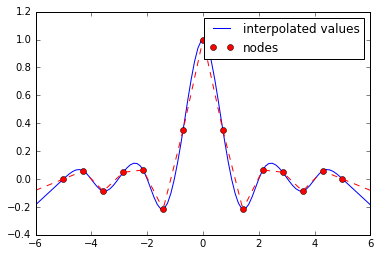

In [12]:
figure()
plot(points[:,1], interpolated_values,"-",label="interpolated values", color='blue')
# plot(points[:,1], f(points[:,0], points[:,1]),":", color="black",label="true values")



nodes = linspace(a[1], b[1], orders[1])
plot(nodes, f(0*nodes,nodes),"o", color="red", label="nodes" )

# compare with linear
from interpolation.splines import LinearSpline
plot(points[:,1], LinearSpline(a,b,orders,vals)(points), color='red',linestyle='--' )
legend()

## Multi splines

Sometimes, it is useful, to interpolate several functions at the same points. In that case, the MultiCubicSpline
can be used instead of CubicSpline.

Let's define $g(x,y) = exp(-x^2-y^2)$


In [13]:
# We define the new function and evaluate it on the same set of points
g = lambda x,y: exp(-x**2-y**2)  # ne need to vectorize it manually since we use only ufuncs here
vals2 = g(x_array, y_array)

By convention, the values are given as an array whose first index corresponds to the number of the spline.
For this reason, we concatenate the two set of values `vals` and `vals2` by creating a new last dimension.
Note that in the resulting array `mvals`, vector values are contiguous in memory (if C-ordered).

In [14]:
mvals = concatenate([vals[:,None], vals2[:,None]],axis=1)

In [15]:
from interpolation.splines import CubicSplines
interp = CubicSplines(a,b,orders,mvals)

ORders
[15 15]
(15, 15, 2)


The interpolation is made exactly as before but the returned objects have one more dimension:

In [16]:
interp(x0)  # returns a one dimensional array with two elements instead of a float

array([ 0.98042839,  0.9884649 ])

In [17]:
# to evaluate it many times, it is more efficient to supply an array of points
# where each line containt the coordinates of one point
vec = linspace(-6.0, 6.0, 100)
points = column_stack([ vec*0, vec ])
interpolated_values = interp(points)
display("Array of points")
display((points[:10,:])) # first 10 points
display(points.shape)
display("Array of interpolated values")
display(interpolated_values[:10]) # first 10 interpolated values
display(interpolated_values.shape)

'Array of points'

array([[-0.        , -6.        ],
       [-0.        , -5.87878788],
       [-0.        , -5.75757576],
       [-0.        , -5.63636364],
       [-0.        , -5.51515152],
       [-0.        , -5.39393939],
       [-0.        , -5.27272727],
       [-0.        , -5.15151515],
       [-0.        , -5.03030303],
       [-0.        , -4.90909091]])

(100, 2)

'Array of interpolated values'

array([[ -1.85261596e-01,   4.69322844e-05],
       [ -1.62805645e-01,   4.12435244e-05],
       [ -1.40349694e-01,   3.55547643e-05],
       [ -1.17893743e-01,   2.98660042e-05],
       [ -9.54377916e-02,   2.41772442e-05],
       [ -7.29818407e-02,   1.84884841e-05],
       [ -5.05258897e-02,   1.27997240e-05],
       [ -2.80699387e-02,   7.11096397e-06],
       [ -5.61398774e-03,   1.42220390e-06],
       [  1.66888656e-02,  -4.19742306e-06]])

(100, 2)

# Low level interface (TODO)

TODO: explain how basis splines are defined on *knots* and how to directly deal with the spline coefficients.

In [18]:
# fit coefficients of the spline (note the size of the matrix ( 15+2 x 15+2 )
from interpolation.splines.filter_cubic import filter_coeffs
coeffs = filter_coeffs(a,b,orders,vals)
display(coeffs.shape)

(17, 17)

In [19]:
# cartesian product with 50 points along each dimension
fine_grid = mlinspace( [0,0], [3,3], [10,10] )

In [22]:
from interpolation.splines.eval_cubic import vec_eval_cubic_spline, vec_eval_cubic_splines_G

# evaluate the spline
V = vec_eval_cubic_spline( a, b, orders, coeffs, fine_grid );

# evaluate with gradient
V, dV = vec_eval_cubic_splines_G( a, b, orders, coeffs[...,None], fine_grid );
V = V[:,0]
dV = dV[:,:,0]

In [30]:
dV_m_1.shape

(10, 10)

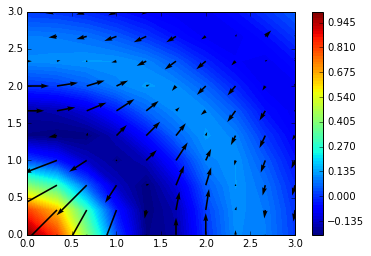

In [32]:
xm = fine_grid[:,0].reshape((10,10))
ym = fine_grid[:,1].reshape((10,10))
V_mesh = V.reshape((10,10))
contourf(xm,ym,V_mesh,100)
colorbar()
# add gradient field
# see api of quiver at http://matplotlib.org/api/pyplot_api.html
dV_m_1 = dV[:,0].reshape((10,10))
dV_m_2 = dV[:,1].reshape((10,10))
streamplot( linspace(a[0], a[0], 10), linspace(b[1], b[1], 10), dV_m_1, dV_m_2)
quiver( linspace(0,3, 10), linspace(0,3, 10), dV_m_1, dV_m_2)
